In [1]:
from transformers import pipeline
from PIL import Image
import numpy as np
import pandas as pd
import time

In [2]:
segmenter = pipeline("image-segmentation", model="mattmdjaga/segformer_b2_clothes")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Set up functions to Segment Clothes

In [3]:
# Initialize segmentation pipeline
def segment_clothing(img, clothes= ["Upper-clothes", "Pants", "Belt"]):
    # Segment image
    segments = segmenter(img)

    # Create list of masks
    mask_list = []
    for s in segments:
        if(s['label'] in clothes):
            mask_list.append(s['mask'])


    # Paste all masks on top of eachother 
    final_mask = np.array(mask_list[0])
    for mask in mask_list:
        current_mask = np.array(mask)
        final_mask = final_mask + current_mask
            
    # Convert final mask from np array to PIL image
    final_mask = Image.fromarray(final_mask)

    # Apply mask to original image
    img.putalpha(final_mask)

    # display the image
    return img

In [4]:
def batch_segment_clothing(img_dir, out_dir, clothes= ["Hat", "Upper-clothes", "Skirt", "Pants", "Dress", "Belt", "Left-shoe", "Right-shoe", "Scarf"]):
    # Create output directory if it doesn't exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Iterate through each file in the input directory
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg") or filename.endswith(".JPG") or filename.endswith(".png") or filename.endswith(".PNG"):
            try:
                # Load image
                img_path = os.path.join(img_dir, filename)
                img = Image.open(img_path).convert("RGBA")

                # Segment clothing
                segmented_img = segment_clothing(img, clothes)

                # Save segmented image to output directory as PNG
                out_path = os.path.join(out_dir, filename.split('.')[0] + ".png")
                segmented_img.save(out_path)

                print(f"Segmented {filename} successfully.")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

        else:
            print(f"Skipping {filename} as it is not a supported image file.")

# scrape website and create csv file

In [5]:
from playwright.async_api import async_playwright

playwright = await async_playwright().start()

browser = await playwright.chromium.launch(headless=True)

page = await browser.new_page()

In [6]:
async def scroll_to_bottom(page):
    
    await page.evaluate("window.scrollTo(0, document.body.scrollHeight);")

##### Ralph_Lauren

In [7]:
RL_url = "https://www.ralphlauren.com/women-clothing-shop-new-arrivals" 
await page.goto(RL_url)

<Response url='https://www.ralphlauren.com/women-clothing-shop-new-arrivals' request=<Request url='https://www.ralphlauren.com/women-clothing-shop-new-arrivals' method='GET'>>

In [8]:
RL = []
while True:
            rl = await page.eval_on_selector_all(
                "[srcset]",
                "elements => elements.map(el => el.getAttribute('srcset'))"
            )
            RL.extend(rl)

            
            next_button = await page.query_selector('a.more-button[title="View 30 more"]')
            if next_button:
                await next_button.click()
                time.sleep(2)
            else:
                break

TimeoutError: ElementHandle.click: Timeout 30000ms exceeded.
Call log:
attempting click action
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #1
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #2
  -   waiting 20ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #3
  -   waiting 100ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #4
  -   waiting 100ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #5
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #6
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #7
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #8
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #9
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #10
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #11
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #12
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #13
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #14
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #15
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #16
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #17
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #18
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #19
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #20
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #21
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #22
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #23
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #24
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #25
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #26
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #27
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #28
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #29
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #30
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #31
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #32
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #33
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #34
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #35
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #36
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #37
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #38
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #39
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #40
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #41
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #42
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #43
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #44
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #45
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #46
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling
  -   <div class="ui-widget-overlay ui-front"></div> intercepts pointer events
  - retrying click action, attempt #47
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is visible, enabled and stable
  -   scrolling into view if needed
  -   done scrolling


#### Uniqlo

In [10]:
uniqlo='https://www.uniqlo.com/us/en/feature/new/women'
await page.goto(uniqlo)
await scroll_to_bottom(page)
await page.wait_for_timeout(1000)
unq= await page.eval_on_selector_all(
    "div.fr-ec-product-tile-resize-wrapper img.fr-ec-image__img",
    "elements => elements.map(e => e.src)"
)

### Zara

In [31]:
Zara="https://www.zara.com/us/en/woman-best-sellers-l5912.html?v1=2491343&regionGroupId=41"
await page.goto(Zara)
await page.locator("body").wait_for()
last_height = await page.evaluate("document.body.scrollHeight")

while True:
    await page.evaluate("window.scrollTo({left: 0, top: document.body.scrollHeight, behavior: 'smooth'})")
    await page.wait_for_load_state("networkidle", timeout=5000)
    await page.wait_for_timeout(2000)
    new_height = await page.evaluate("document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

In [32]:
zara = await page.eval_on_selector_all(
    'img[data-qa-qualifier="media-image"]',
            "elements => elements.map(e => e.src)"
        )
zara = [e for e in zara if 'background' not in e]

### HM

In [15]:
hm = "https://www2.hm.com/en_us/women/new-arrivals/view-all.html"
await page.goto(hm)
all_links = []
while True:
        hm = await page.eval_on_selector_all(
            'img[imagetype="PRODUCT_IMAGE"]',
            "elements => elements.map(e => e.srcset)"
        )
        all_links.extend(hm)
           
        next_button = await page.query_selector('button[data-elid="pagination-hybrid-button"]')
        if next_button:
            await next_button.click()
            time.sleep(2)
        else:
            break

TimeoutError: ElementHandle.click: Timeout 30000ms exceeded.
Call log:
attempting click action
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #1
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #2
  -   waiting 20ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #3
  -   waiting 100ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #4
  -   waiting 100ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #5
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #6
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #7
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #8
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #9
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #10
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #11
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #12
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #13
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #14
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #15
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #16
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #17
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #18
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #19
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #20
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #21
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #22
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #23
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #24
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #25
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #26
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #27
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #28
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #29
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #30
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #31
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #32
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #33
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #34
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #35
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #36
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #37
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #38
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #39
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #40
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #41
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #42
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #43
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #44
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #45
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #46
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #47
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #48
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #49
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #50
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #51
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #52
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #53
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #54
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #55
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #56
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #57
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #58
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #59
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #60
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #61
  -   waiting 500ms
  -   waiting for element to be visible, enabled and stable
  -   element is not enabled
  - retrying click action, attempt #62
  -   waiting 500ms


In [51]:
hm = [h.split(', ')[-1] for h in all_links if len(h)>10]
hm = [h.split(' ')[0] for h in hm]

In [53]:
links=[]
d = pd.DataFrame({'ExistingColumn': range(100)})

In [35]:
def adjust_length(values, target_length):
    if len(values) < target_length:
        return values + ['N/A'] * (target_length - len(values))
    else:
        return values[:target_length]

In [54]:
rl_extended = adjust_length(RL, len(d))
unq_extended = adjust_length(unq, len(d))
zara_extended = adjust_length(zara, len(d))
hm_extended = adjust_length(hm, len(d))

d['Ralph_Lauren'] = rl_extended
d['Uniqlo'] = unq_extended
d['Zara'] = zara_extended
d['HM'] = hm_extended

links.append(d)

In [55]:
d.drop(columns='ExistingColumn', errors='ignore', inplace=True)
d.to_csv('Image_Sources.csv',index=False)

In [56]:
d.head()

,Ralph_Lauren,Uniqlo,Zara,HM
0,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/fdd4/9f5...,https://image.hm.com/assets/hm/af/87/af8715f8a...
1,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/32c9/b5d...,https://image.hm.com/assets/hm/32/ce/32cec5d01...
2,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/cc84/cec...,https://image.hm.com/assets/hm/88/97/88973cd20...
3,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/3fc9/b8e...,https://image.hm.com/assets/hm/ac/62/ac6261d3b...
4,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/4c3b/223...,https://image.hm.com/assets/hm/f4/2a/f42a4f128...


# Read url from the csv file & Segmentation

In [39]:
import urllib.request
from urllib.parse import unquote, urlparse
import re
import os

In [23]:
def clean_filename(url):
    # Get the filename without query parameters
    path = urlparse(url).path  
    filename = os.path.basename(path)  
    

    filename = unquote(filename)
    
    return filename

In [64]:
path_files=[]
dic={}
for col in d.columns:
    links=d[col]
    # Create a folder for the current column
    os.makedirs(col, exist_ok=True)
    paths=[]
     
    for l in links:
        try:
            # URL of the file to download
            url = l

            # Extract the filename from the URL
            filename = url.split("/")[-1]  # Default fallback if Content-Disposition is not available
            filename = unquote(filename)  # Decode URL-encoded characters in the filename

            # Combine column name folder path with filename
            filepath = os.path.join(col, filename)
            
            # Download and save the file
            urllib.request.urlretrieve(url, filepath)            
            print(f"File downloaded and saved as: {filepath}")
            time.sleep(1)
                        
            # open the file
            image=Image.open(filepath)

            # segment the clothes
            result = segment_clothing(img=image)
            result.save(f'{filepath}.png')
            paths.append(f'{filepath}.png')
    
        except:
            print("This image cound't be found:",l)

    dic[col]=paths
    path_files.append(dic)

File downloaded and saved as: Ralph_Lauren/s7-1470157_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1470157_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Lauren/s7-1470157_lifestyle?$plpDeskRF$
File downloaded and saved as: Ralph_Lauren/s7-1470157_lifestyle?$plpMob$
File downloaded and saved as: Ralph_Lauren/s7-AI211959908001_alternate1?$plpDeskRF$
This image cound't be found: https://dtcralphlauren.scene7.com/is/image/PoloGSI/s7-AI211959908001_alternate1?$plpDeskRF$
File downloaded and saved as: Ralph_Lauren/s7-AI211959908001_alternate1?$plpMob$
This image cound't be found: https://dtcralphlauren.scene7.com/is/image/PoloGSI/s7-AI211959908001_alternate1?$plpMob$
File downloaded and saved as: Ralph_Lauren/s7-AI211959908001_lifestyle?$plpDeskRF$
File downloaded and saved as: Ralph_Lauren/s7-AI211959908001_lifestyle?$plpMob$
File downloaded and saved as: Ralph_Lauren/s7-1501737_alternate10?$plpDeskRFAlt$
File downloaded and saved as: Ralph_Laure

# read the colors

In [30]:
# pip install Pillow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 8.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 8.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [62]:
def extract_colors(image_path, num_colors=5):
    img = Image.open(image_path)
    # Ensure image is in RGB format
    img = img.convert('RGB')
    
    img = img.resize((256, 256))  # Resize for faster processing
    img_array = np.array(img)
    img_array = img_array.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(img_array)
    colors = kmeans.cluster_centers_.astype(int)
    return colors

# Make a color palette

In [80]:
def luminance(color):
    r, g, b = color
    return 0.299 * r + 0.587 * g + 0.114 * b

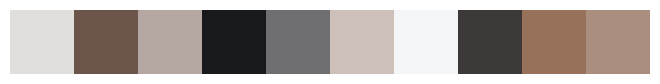

In [83]:
palettes=[]
for brand,paths in path_files[1].items():
    image_paths = paths  # Add your image paths
    all_colors = []
        
    for path in image_paths:
        colors = extract_colors(path)
        all_colors.extend(colors)
    try:    
        final_palette = KMeans(n_clusters=10).fit(all_colors).cluster_centers_.astype(int)
        palettes.append(final_palette)
    except:
        print(f"{brand} has an error")
    
    plt.imshow([final_palette])
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    plt.savefig(f'{brand}.png', transparent=True, bbox_inches='tight', pad_inches=0)

I consult google for this

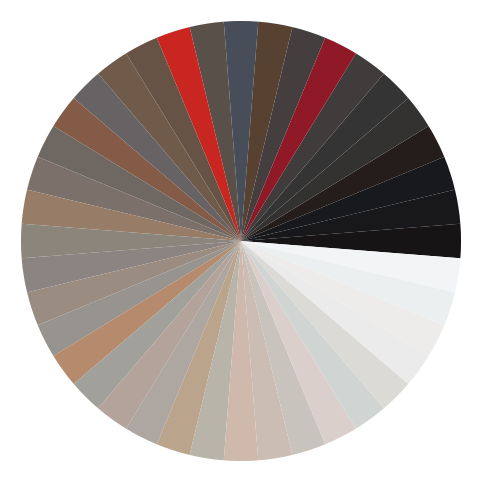

In [81]:
# Convert the final palette to a usable color format
final_colors = [tuple(color / 255) for palette in palettes for color in palette]  
final_colors = sorted(final_colors, key=luminance)

# Number of colors
num_colors = len(final_colors)

# Angles
angles = np.linspace(0, 2 * np.pi, num_colors, endpoint=False)

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
bars = ax.bar(angles, np.ones(num_colors), color=final_colors, width=2 * np.pi / num_colors)

# Remove radial and angular ticks
ax.set_yticks([])
ax.set_xticks([])
ax.spines['polar'].set_visible(False)

plt.savefig('color_wheel.png', transparent=True)

# Find the most commonly appeared color

In [49]:
from collections import Counter

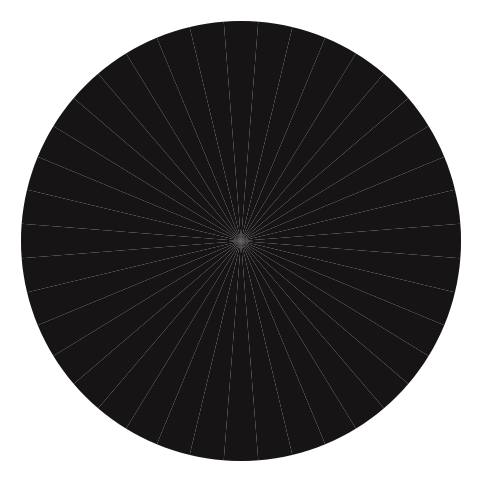

In [67]:
color_counts = Counter(final_colors)
most_common_color, _ = color_counts.most_common(1)[0]

fig2, ax2 = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
ax2.bar(angles, np.ones(num_colors), color=[most_common_color] * num_colors, width=2 * np.pi / num_colors)


ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['polar'].set_visible(False)

plt.savefig('most_common_color_wheel.png', transparent=True)

# Build a color count table

In [75]:
color_table = pd.DataFrame(color_counts.items(), columns=['Color (RGB)', 'Occurrences'])

color_table = color_table.sort_values(by='Occurrences', ascending=False).reset_index(drop=True)

color_table.head()

,Color (RGB),Occurrences
0,"(0.08627450980392157, 0.0784313725490196, 0.07...",1
1,"(0.7333333333333333, 0.6431372549019608, 0.549...",1
2,"(0.09411764705882353, 0.09019607843137255, 0.0...",1
3,"(0.6313725490196078, 0.6274509803921569, 0.607...",1
4,"(0.9254901960784314, 0.9372549019607843, 0.941...",1


In [79]:
kmeans = KMeans(n_clusters=2).fit(final_colors)
print(kmeans.labels_)

[0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0
 1 0 1]
